# <center><font color = 'crimson'>Solar Irradiance Prediction<font/><center/>

### <i>Table of Content<i/>

1. [**Importing Libraries**](#import)
2. [**Reading Data**](#load_data)
3. [**Data Wrangling**](#data_wrangling)
4. [**Feature Selection using Correlation Matrix**](#correlation_matrix)
5. [**Feature Selection using SelectKBest Method**](#kbest_method)
6. [**Feature Selection using Extra Tree Classifier**](#extra_tree)
7. [**Feature Engineering with BoxCox, Log, Min-Max and Standard transformation**](#feature_engg)
8. [**Preparing data - Standardisation and Splitting**](#data_prep)
9. [**Prediction with XGBoost**](#xgboost)
10. [**Using MultiLayer Perceptron for prediction**](#perceptron)

# <font color = 'green'>Importing Libraries<font/><a class = 'anchor' id = 'import'/>

In [1]:
import re
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy import stats
from collections import Counter
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
warnings.filterwarnings("ignore")

In [3]:
plt.rcParams['figure.figsize'] = (12,6)

# <font color = 'violet'>Loading Data<font/><a class = 'anchor' id = 'load_data'/>

In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
data = pd.read_csv("SolarPrediction.csv")

In [6]:
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [7]:
data.shape

(32686, 11)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


# <font color = 'blue'>Data Wrangling<font/><a class = 'anchor' id = 'data_wrangling'/>

In [9]:
df = data.copy()

In [10]:
# extract the date from the date_time format of the 'Data' parameter

df['Data'] = df['Data'].apply(lambda x : x.split()[0])

In [11]:
# extract the date time features from the given parameter using date time python methods

df['Month'] = pd.to_datetime(df['Data']).dt.month
df['Day'] = pd.to_datetime(df['Data']).dt.day

df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['Minute'] = pd.to_datetime(df['Time']).dt.minute
df['Second'] = pd.to_datetime(df['Time']).dt.second

In [12]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24


In [13]:
# extract the sunrise and sunset information using regular expression

df['risehour'] = df['TimeSunRise'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['riseminute'] = df['TimeSunRise'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

df['sethour'] = df['TimeSunSet'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['setminute'] = df['TimeSunSet'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

In [14]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26,6,13,18,13
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23,6,13,18,13
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26,6,13,18,13
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21,6,13,18,13
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24,6,13,18,13


In [15]:
# drop the parameters that are not required after extracting the relevant information

df.drop(['UNIXTime', 'Data', 'Time', 'TimeSunRise', 'TimeSunSet'], axis = 1, inplace = True)

In [16]:
df.shape

(32686, 15)

In [17]:
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [18]:
np.array(df['Radiation'])

array([1.21, 1.21, 1.23, ..., 1.2 , 1.23, 1.2 ])

In [19]:
input_features = df.drop('Radiation', axis = 1)
target = df['Radiation']

# <font color = 'pink'>Feature Selection using Correlation Matrix<font/><a class = 'anchor' id = 'correlation_matrix'/>

$$
r=\frac{\sum\left(x_i-\bar{x}\right)\left(y_i-\bar{y}\right)}{\sqrt{\sum\left(x_i-\bar{x}\right)^2 \sum\left(y_i-\bar{y}\right)^2}}
$$
- $r=$ correlation coefficient
- $x_i=$ values of the $\mathrm{x}$-variable in a sample
- $\bar{x}=$ mean of the values of the $\mathrm{x}$-variable
- $y_i=$ values of the $y$-variable in a sample
- $\bar{y}=$ mean of the values of the $y$-variable

In [20]:
# extract the correlation between the data features

df.corr()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
Radiation,1.000000,0.734955,0.119016,-0.226171,-0.230324,0.073627,-0.095450,0.039978,0.004398,-0.000730,-0.031270,NaN,-0.092850,0.048719,-0.039816
Temperature,0.734955,1.000000,0.311173,-0.285055,-0.259421,-0.031458,-0.354560,-0.123705,0.197464,-0.001934,-0.036147,NaN,-0.380968,0.300920,-0.242881
Pressure,0.119016,0.311173,1.000000,-0.223973,-0.229010,-0.083639,-0.341759,-0.024633,0.091069,0.001860,-0.031102,NaN,-0.380399,0.151939,-0.119599
Humidity,-0.226171,-0.285055,-0.223973,1.000000,-0.001833,-0.211624,-0.068854,0.014637,0.077899,0.000499,-0.027682,NaN,-0.023955,0.145143,-0.119526
WindDirection(Degrees),-0.230324,-0.259421,-0.229010,-0.001833,1.000000,0.073092,0.181485,-0.082354,-0.077969,-0.000602,-0.032568,NaN,0.176929,-0.078540,0.070030
Speed,0.073627,-0.031458,-0.083639,-0.211624,0.073092,1.000000,0.150822,0.117337,-0.057939,0.000192,-0.032934,NaN,0.167075,-0.159384,0.119926
Month,-0.095450,-0.354560,-0.341759,-0.068854,0.181485,0.150822,1.000000,0.038027,-0.005396,0.000168,0.220563,NaN,0.952472,-0.784783,0.541883
Day,0.039978,-0.123705,-0.024633,0.014637,-0.082354,0.117337,0.038027,1.000000,-0.008010,-0.000196,0.089078,NaN,0.274522,-0.263575,0.265662
Hour,0.004398,0.197464,0.091069,0.077899,-0.077969,-0.057939,-0.005396,-0.008010,1.000000,-0.004052,0.004199,NaN,-0.006772,0.008629,-0.007056
Minute,-0.000730,-0.001934,0.001860,0.000499,-0.000602,0.000192,0.000168,-0.000196,-0.004052,1.000000,0.002517,NaN,-0.000158,0.001052,-0.002215


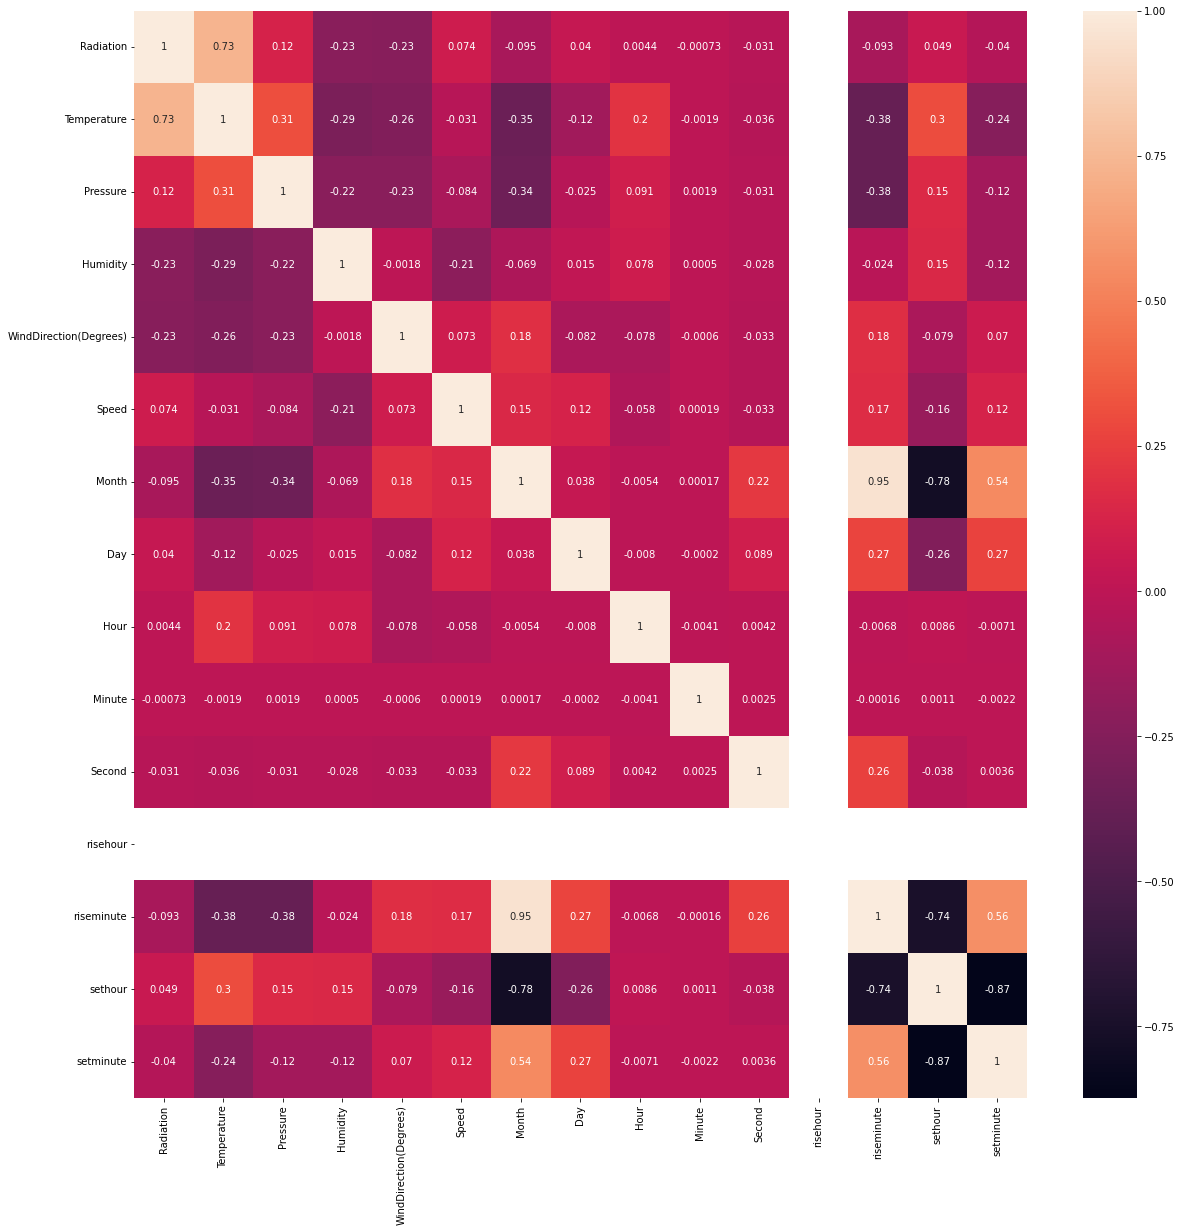

In [21]:
# plot the correlation matrix using heatmap for clear understanding

plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot = True)
plt.show()

# <font color = 'yellow'>Feature Selection using SelectKBest Method<font/><a class = 'anchor' id = 'kbest_method'/>

In [22]:
target

0        1.21
1        1.21
2        1.23
3        1.21
4        1.17
         ... 
32681    1.22
32682    1.17
32683    1.20
32684    1.23
32685    1.20
Name: Radiation, Length: 32686, dtype: float64

It works on the target label but instead we are passsing continuous float values to it. So, we need to convert our data to label form and there are two methods as follows:
- using LabelEncoder
- multiplying the data by 100 and converting it to int which can be treated as labels by the model

In [23]:
# using LabelEncoder

label_encoder = LabelEncoder()
train_Y = label_encoder.fit_transform(target)

In [24]:
train_Y

array([ 9,  9, 11, ...,  8, 11,  8], dtype=int64)

In [25]:
# multiplying the data by 100 and converting it to int which can be treated as labels by the model

target_cont = df['Radiation'].apply(lambda x : int(x*100))

In [26]:
target_cont

0        121
1        121
2        123
3        121
4        117
        ... 
32681    122
32682    117
32683    120
32684    123
32685    120
Name: Radiation, Length: 32686, dtype: int64

In [27]:
# scaling input features

scaled_input_features = MinMaxScaler().fit_transform(input_features)

In [28]:
# performing SelectKBest() method

bestfeatures = SelectKBest(score_func = chi2, k = 10)
fit = bestfeatures.fit(scaled_input_features, target_cont)

In [29]:
scores = pd.DataFrame(fit.scores_)
column = pd.DataFrame(input_features.columns)

In [30]:
# contatinating data_features with the scores
featureScores = pd.concat([column, scores], axis=1)

#naming the dataframe columns
featureScores.columns = ['Features', 'feature_imp'] 

In [31]:
# best features

featureScores.sort_values(by = 'feature_imp', ascending=False, inplace=True)
featureScores

,Features,feature_imp
12,sethour,12207.531454
5,Month,4684.579610
11,riseminute,4015.062771
3,WindDirection(Degrees),3271.827277
6,Day,2841.926850
8,Minute,2702.449333
9,Second,2288.673032
13,setminute,1863.712087
0,Temperature,1651.685632
2,Humidity,1588.087433


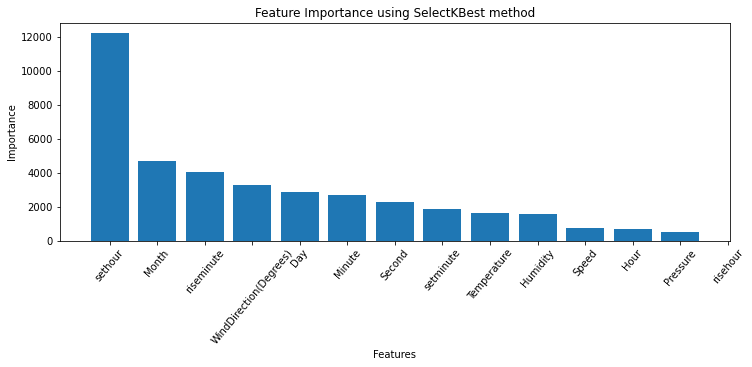

In [32]:
# visualise the feature importance

plt.figure(figsize = (12, 4))
plt.bar(featureScores.Features, featureScores.feature_imp)
plt.xticks(rotation = 50)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance using SelectKBest method")
plt.show()

# <font color = 'green'>Feature Selection using Extra Tree Classifier<font/><a class = 'anchor' id = 'extra_tree'/>

# <font color = 'red'>Feature Engineering with BoxCox, Log, Min-Max and Standard transformation<font/><a class = 'anchor' id = 'feature_engg'/>

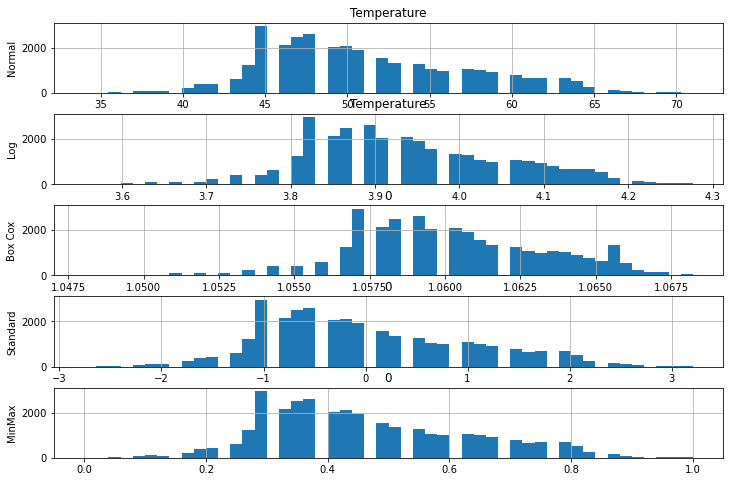

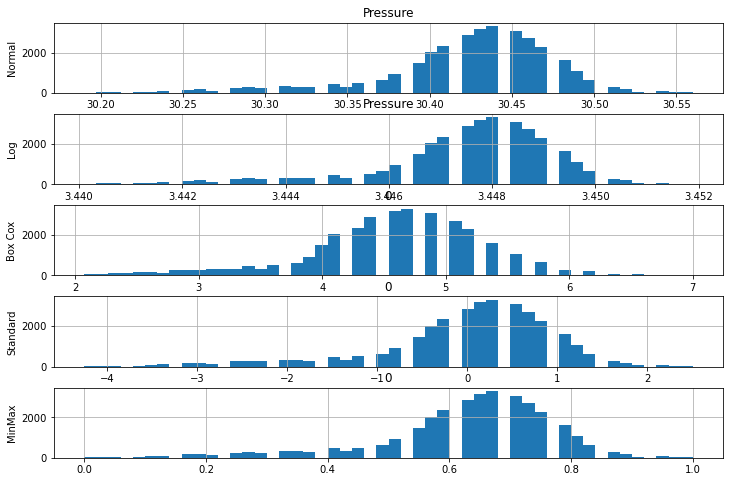

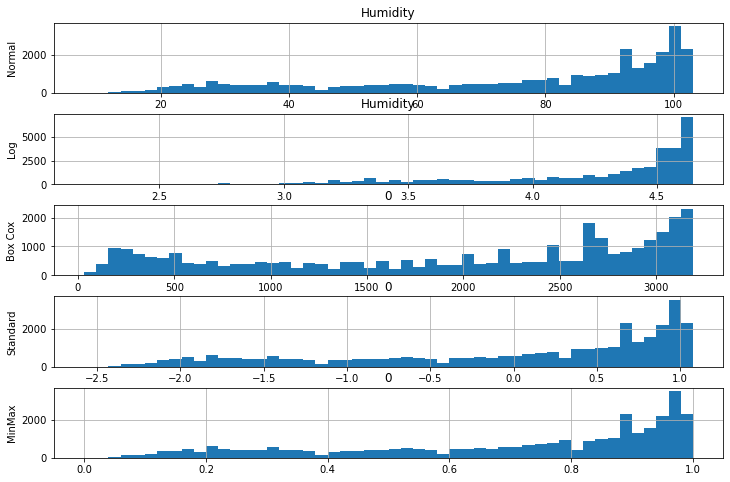

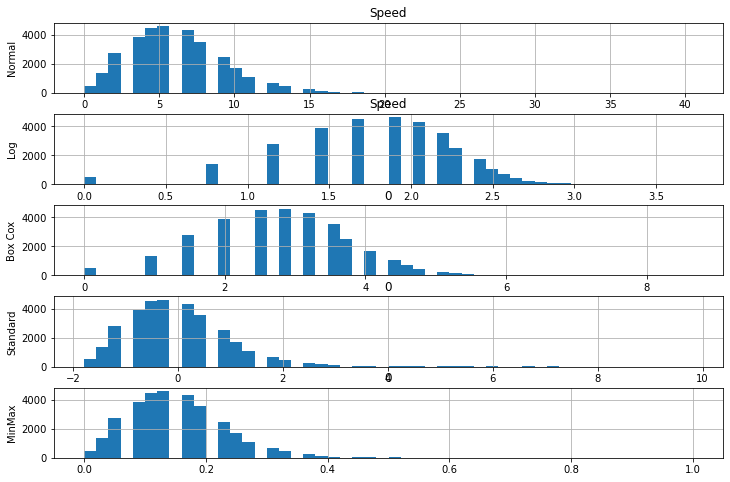

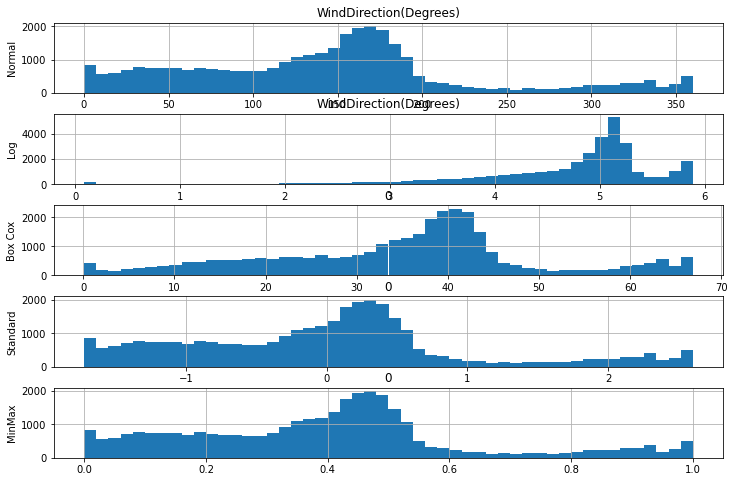

In [38]:
# Looking for transformation

features_to_transform = ['Temperature', 'Pressure', 'Humidity', 'Speed', 'WindDirection(Degrees)']

for i in features_to_transform:
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 8))
    
    pd.DataFrame(input_features[i]).hist(ax = ax1, bins = 50)
    pd.DataFrame((input_features[i]+1).transform(np.log)).hist(ax = ax2, bins = 50)
    pd.DataFrame(stats.boxcox(input_features[i]+1)[0]).hist(ax = ax3, bins = 50)    
    pd.DataFrame(StandardScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax = ax4, bins = 50)
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax = ax5, bins = 50)
    
    ax1.set_ylabel('Normal')
    ax2.set_ylabel('Log')
    ax3.set_ylabel('Box Cox')
    ax4.set_ylabel('Standard')
    ax5.set_ylabel('MinMax')

In [39]:
input_features.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [40]:
# set the transformations required

transform = {'Temperature' : (input_features['Temperature']+1).transform(np.log), 
             'Pressure': stats.boxcox(input_features['Pressure']+1)[0], 
             'Humidity' : stats.boxcox(input_features['Humidity']+1)[0], 
             'Speed' : (input_features['Speed']+1).transform(np.log), 
             'WindDirection(Degrees)' : MinMaxScaler().fit_transform(
                 np.array(input_features['WindDirection(Degrees)']).reshape(-1, 1))}

for i in transform:
    input_features[i] = transform[i]

In [41]:
input_features.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,3.89182,5.044903e+152,1139.358665,0.492692,1.890095,9,29,23,55,26,6,13,18,13
1,3.89182,5.044903e+152,1104.046980,0.490996,1.474763,9,29,23,50,23,6,13,18,13
2,3.89182,5.044903e+152,1069.253545,0.440894,1.474763,9,29,23,45,26,6,13,18,13
3,3.89182,5.044903e+152,1175.187489,0.382426,1.474763,9,29,23,40,21,6,13,18,13
4,3.89182,5.044903e+152,1248.392213,0.291391,1.890095,9,29,23,35,24,6,13,18,13


# <font color = 'pink'>Preparing data - Standardisation and Splitting<font/><a class = 'anchor' id = 'data_prep'/>

In [42]:
xtrain, xtest, ytrain, ytest = train_test_split(input_features, target, test_size=0.2, random_state=1)

In [43]:
scaler = StandardScaler()

In [44]:
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [45]:
xtrain.shape, xtest.shape

((26148, 14), (6538, 14))

# <font color = 'yellow'>Prediction with XGBoost<font/><a class = 'anchor' id = 'xgboost'/>

In [46]:
params = {
    'learning_rate': 0.1,
    'max_depth': 8}

In [47]:
model = XGBRegressor(**params)

In [48]:
# train the model

model.fit(xtrain, ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [49]:
y_pred = model.predict(xtest)

In [50]:
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
r2 = r2_score(ytest, y_pred)

print("Testing performance ~")

print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance ~
RMSE: 81.45
R2: 0.93


# <font color = 'cyan'>Using MultiLayer Perceptron for prediction<font/><a class = 'anchor' id = 'perceptron'/>

In [51]:
model = None
model = Sequential()
    
model.add(Dense(128, activation='relu', input_dim=14))
model.add(Dropout(0.33))
    
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(1, activation='linear'))
    
model.compile(metrics='mse', loss='mae', optimizer=Adam(learning_rate=0.001))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1920      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

In [52]:
history = model.fit(xtrain, ytrain, validation_split=0.1, epochs=50, batch_size=32)

Epoch 1/50
736/736 [==============================] - 5s 4ms/step - loss: 122.1349 - mse: 56052.0430 - val_loss: 78.3812 - val_mse: 23379.9414
Epoch 2/50
736/736 [==============================] - 3s 4ms/step - loss: 85.8627 - mse: 28091.5020 - val_loss: 70.1704 - val_mse: 19113.4883
Epoch 3/50
736/736 [==============================] - 3s 4ms/step - loss: 81.6670 - mse: 25463.2402 - val_loss: 66.2093 - val_mse: 17056.7051
Epoch 4/50
736/736 [==============================] - 3s 4ms/step - loss: 79.0983 - mse: 23864.6035 - val_loss: 62.3057 - val_mse: 15089.0264
Epoch 5/50
736/736 [==============================] - 3s 4ms/step - loss: 75.8196 - mse: 22124.7734 - val_loss: 59.4825 - val_mse: 14193.1865
Epoch 6/50
736/736 [==============================] - 3s 4ms/step - loss: 74.6247 - mse: 21742.2031 - val_loss: 59.4037 - val_mse: 14516.0762
Epoch 7/50
736/736 [==============================] - 3s 4ms/step - loss: 72.0806 - mse: 20345.8555 - val_loss: 54.8762 - val_mse: 12719.1729
Epoch

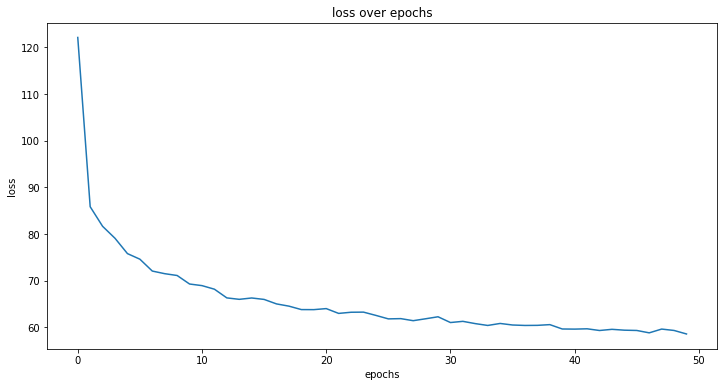

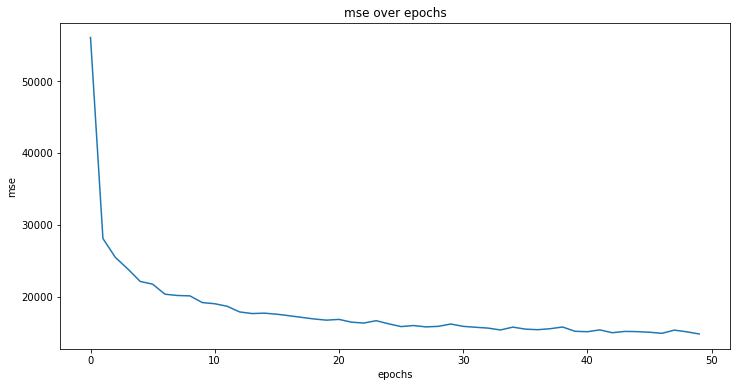

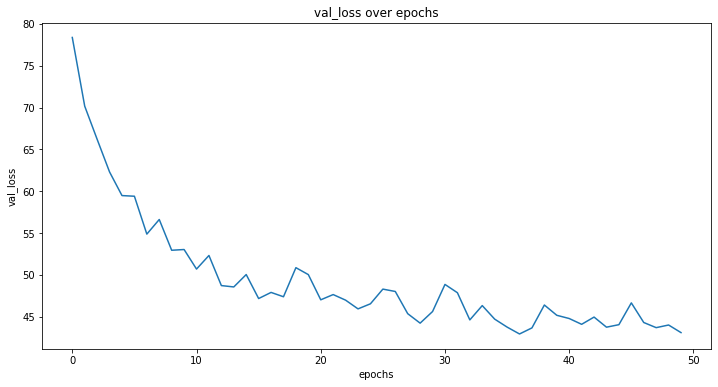

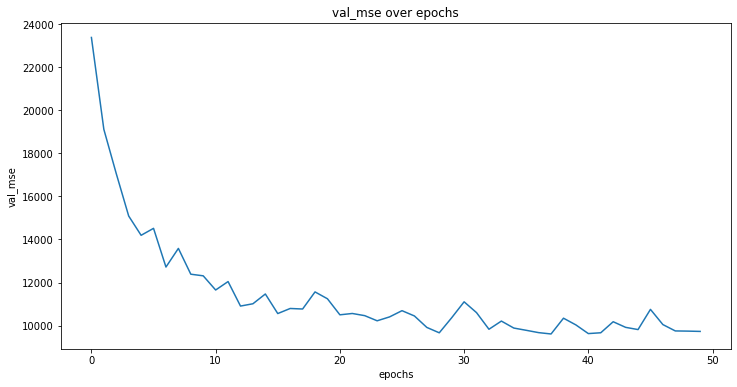

In [53]:
fit = history.history
for i in fit:
    plt.plot(fit[i])
    plt.title(i + ' over epochs')
    plt.ylabel(i)
    plt.xlabel('epochs')
    plt.show()

In [54]:
scores = model.evaluate(xtest, ytest)
mae = scores[0]
mse = scores[1]

205/205 [==============================] - 0s 2ms/step - loss: 41.0817 - mse: 9624.8281


In [55]:
y_pred = model.predict(xtest)

205/205 [==============================] - 1s 2ms/step


In [56]:
r2 = r2_score(ytest, y_pred)
r2

0.9011914263301406

In [57]:
print('Mean absolute error: ', mae)
print('Mean squared error: ', mse)
print("RMSE: {:.2f}".format(rmse))

Mean absolute error:  41.08173751831055
Mean squared error:  9624.828125
RMSE: 81.45
